In [1]:
!pip3 install opencv-python

In [5]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

np.random.seed(42)

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [33]:
class_names = ['pistol','smartphone','knife','purse', 'bill', 'card']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [17]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [19]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

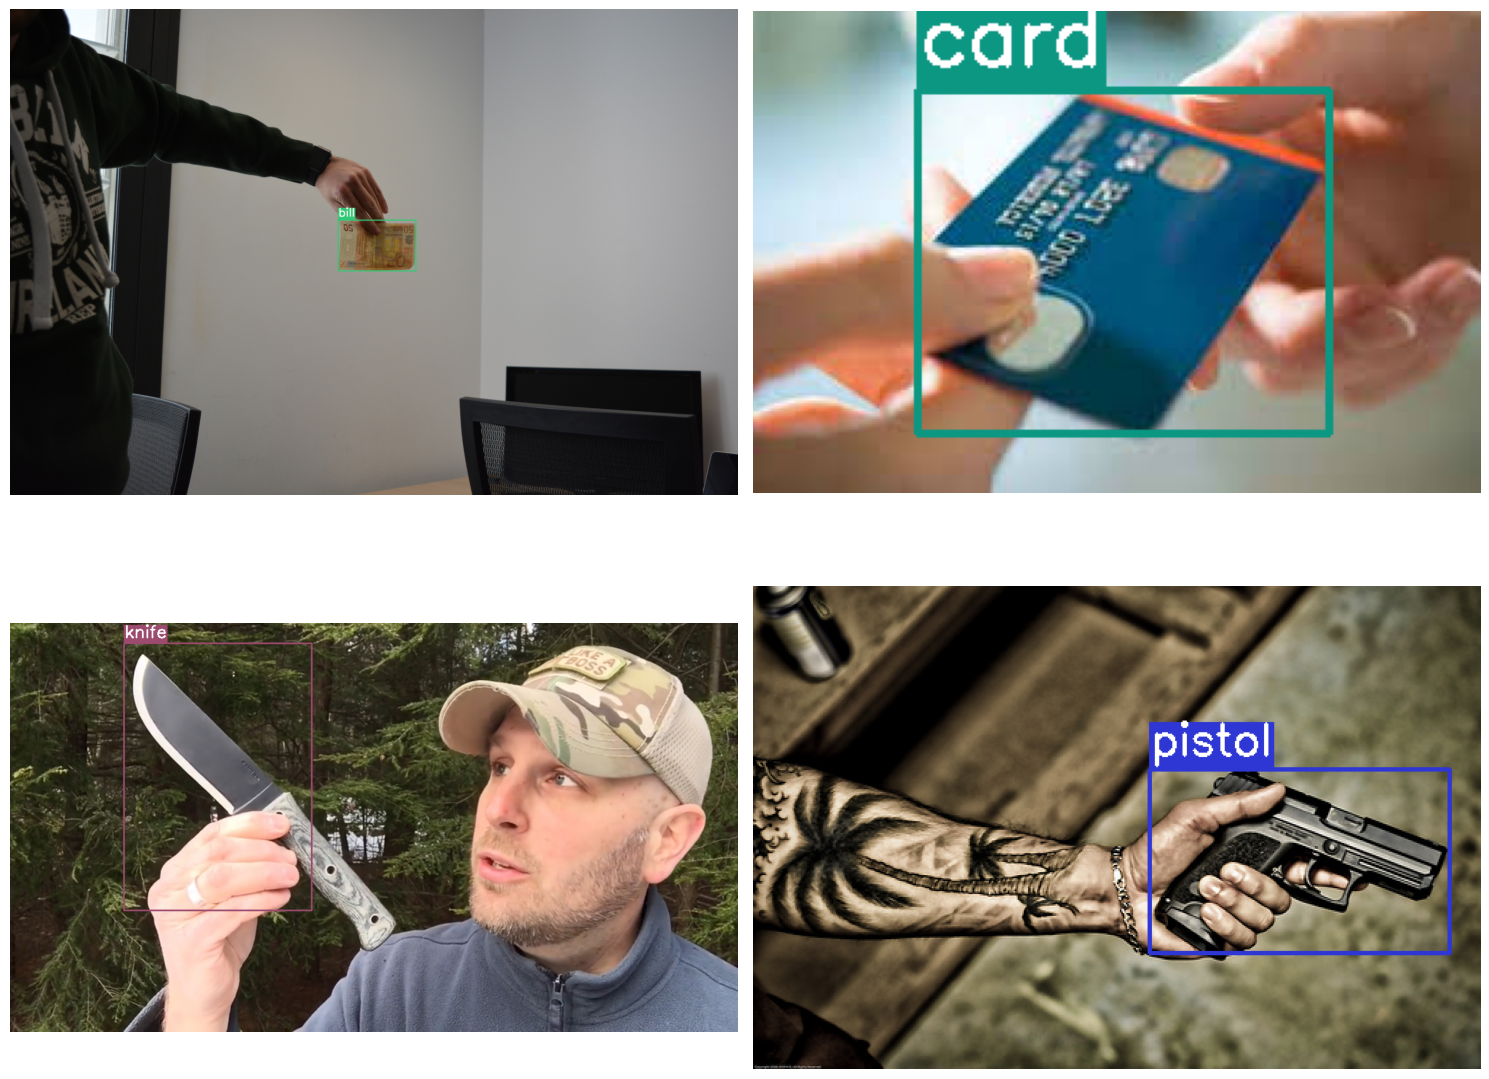

In [31]:
# Visualize a few training images.
plot(
    image_paths='dataset/data/images/train/*', 
    label_paths='dataset/data/labels/train/*',
    num_samples=4,
)

In [11]:
#Obrisane su klase smartphone i purse, i zamenjeni su indeksi klasa bill(4->1) i card(5->3)

# Function for updating indexes in labels files
def update_labels_in_files(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):  
            file_path = os.path.join(directory_path, filename)
            
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            updated_lines = []
            for line in lines:
                label = line[0] 
                if label == '4':
                    new_line = '1' + line[1:]  # bill(4->1)
                elif label == '5':
                    new_line = '3' + line[1:]  # card(5->3)
                else:
                    new_line = line  
                updated_lines.append(new_line)
            
            with open(file_path, 'w') as file:
                file.writelines(updated_lines)

# Train labels files
update_labels_in_files('dataset/data/labels/train')

# Test labels files
update_labels_in_files('dataset/data/labels/test')

Train


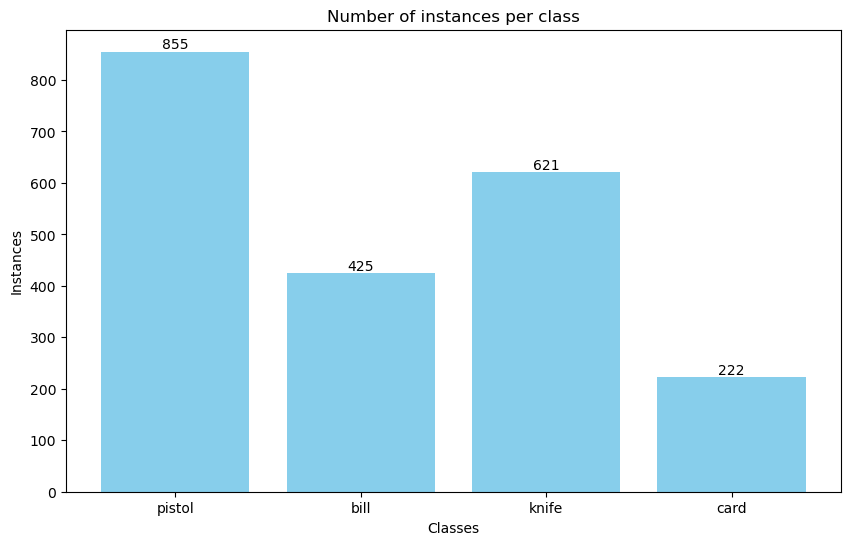

In [13]:
from collections import Counter

label_names = {
    '0': 'pistol',
    '1': 'bill',
    '2': 'knife',
    '3': 'card'
}

def count_objects_per_class(lables_path):
    object_counts = Counter()  

    
    for filename in os.listdir(lables_path):
        if filename.endswith(".txt"):  
            filepath = os.path.join(lables_path, filename)
            with open(filepath, 'r') as f:
                label_lines = f.readlines()
                for label_line in label_lines:
                    label = label_line[0]  
                    object_counts[label] += 1  

    return object_counts

def print_count_objects(object_counts):
    for label, count in object_counts.items():
        object_name = label_names.get(label, "Unknown")
        print(f"Objekat '{object_name}' se pojavljuje {count} puta.")


def plot_object_counts(object_counts):
    sorted_labels = ['0', '1', '2', '3']
    labels = [label_names[label] for label in sorted_labels]
    counts = [object_counts.get(label, 0) for label in sorted_labels]

    plt.figure(figsize=(10, 6))

    bars = plt.bar(labels, counts, color='skyblue')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
    
    plt.xlabel("Classes")
    plt.ylabel("Instances")
    plt.title("Number of instances per class")
    plt.show()


# Train 
print('Train')
object_counts_train = count_objects_per_class('dataset/data/labels/train')
#print_count_objects(object_counts_train)
plot_object_counts(object_counts_train)

Test


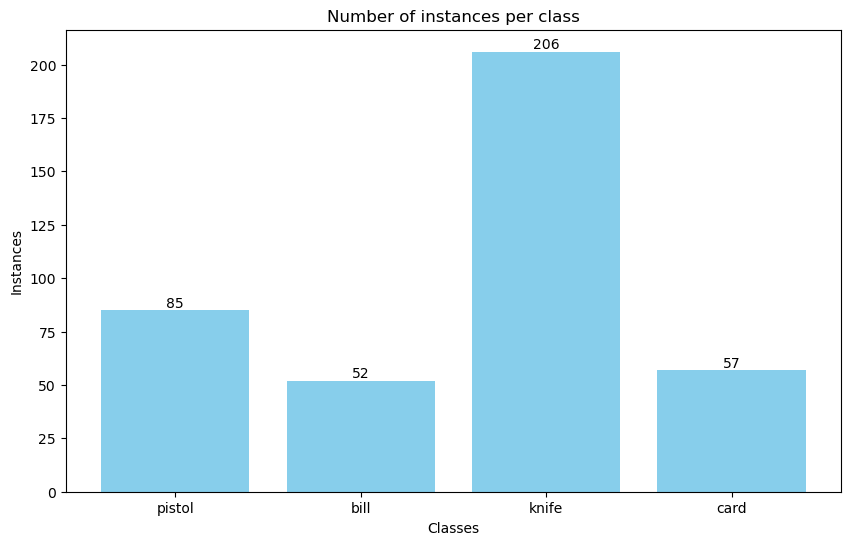

In [15]:
#Test
print('Test')
object_counts_test = count_objects_per_class('dataset/data/labels/test')
#print_count_objects(object_counts_test)
plot_object_counts(object_counts_test)

In [39]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.26  Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 3 3200G with Radeon Vega Graphics)
Setup complete  (4 CPUs, 12.9 GB RAM, 328.6/446.5 GB disk)


In [77]:
# !yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=dataset.yaml epochs=30 batch=16 

In [33]:
import subprocess

# YOLOv8 komanda za treniranje
command = [
    "yolo",
    "task=detect",
    "mode=train",
    "model=yolov8n.pt",
    "imgsz=640",
    "data=dataset.yaml",
    "epochs=25",
    "batch=16"
]

# Pokretanje komande sa real-time ispisom
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# Čitanje izlaza u realnom vremenu
for line in process.stdout:
    print(line, end='')  # Korišćenje end='' sprečava dvostruki prelaz u nov red
process.stdout.close()
process.wait()


  0%|          | 0.00/6.25M [00:00<?, ?B/s]
  2%|2         | 128k/6.25M [00:00<00:11, 580kB/s]
  6%|6         | 384k/6.25M [00:00<00:05, 1.22MB/s]
 10%|#         | 640k/6.25M [00:00<00:03, 1.54MB/s]
 14%|#4        | 896k/6.25M [00:00<00:03, 1.72MB/s]
 18%|#8        | 1.12M/6.25M [00:00<00:02, 1.94MB/s]
 22%|##2       | 1.38M/6.25M [00:00<00:02, 2.05MB/s]
 26%|##6       | 1.62M/6.25M [00:01<00:05, 844kB/s] 
 32%|###2      | 2.00M/6.25M [00:01<00:04, 986kB/s]
 36%|###6      | 2.25M/6.25M [00:02<00:06, 621kB/s]
 42%|####2     | 2.62M/6.25M [00:02<00:04, 784kB/s]
 44%|####4     | 2.75M/6.25M [00:03<00:05, 702kB/s]
 48%|####8     | 3.00M/6.25M [00:03<00:04, 826kB/s]
 50%|#####     | 3.12M/6.25M [00:03<00:04, 766kB/s]
 52%|#####2    | 3.25M/6.25M [00:03<00:04, 776kB/s]
 54%|#####4    | 3.38M/6.25M [00:04<00:04, 615kB/s]
 56%|#####6    | 3.50M/6.25M [00:04<00:04, 624kB/s]
 58%|#####8    | 3.62M/6.25M [00:04<00:04, 663kB/s]
 60%|######    | 3.75M/6.25M [00:04<00:03, 683kB/s]
 64%|######4   | 

0

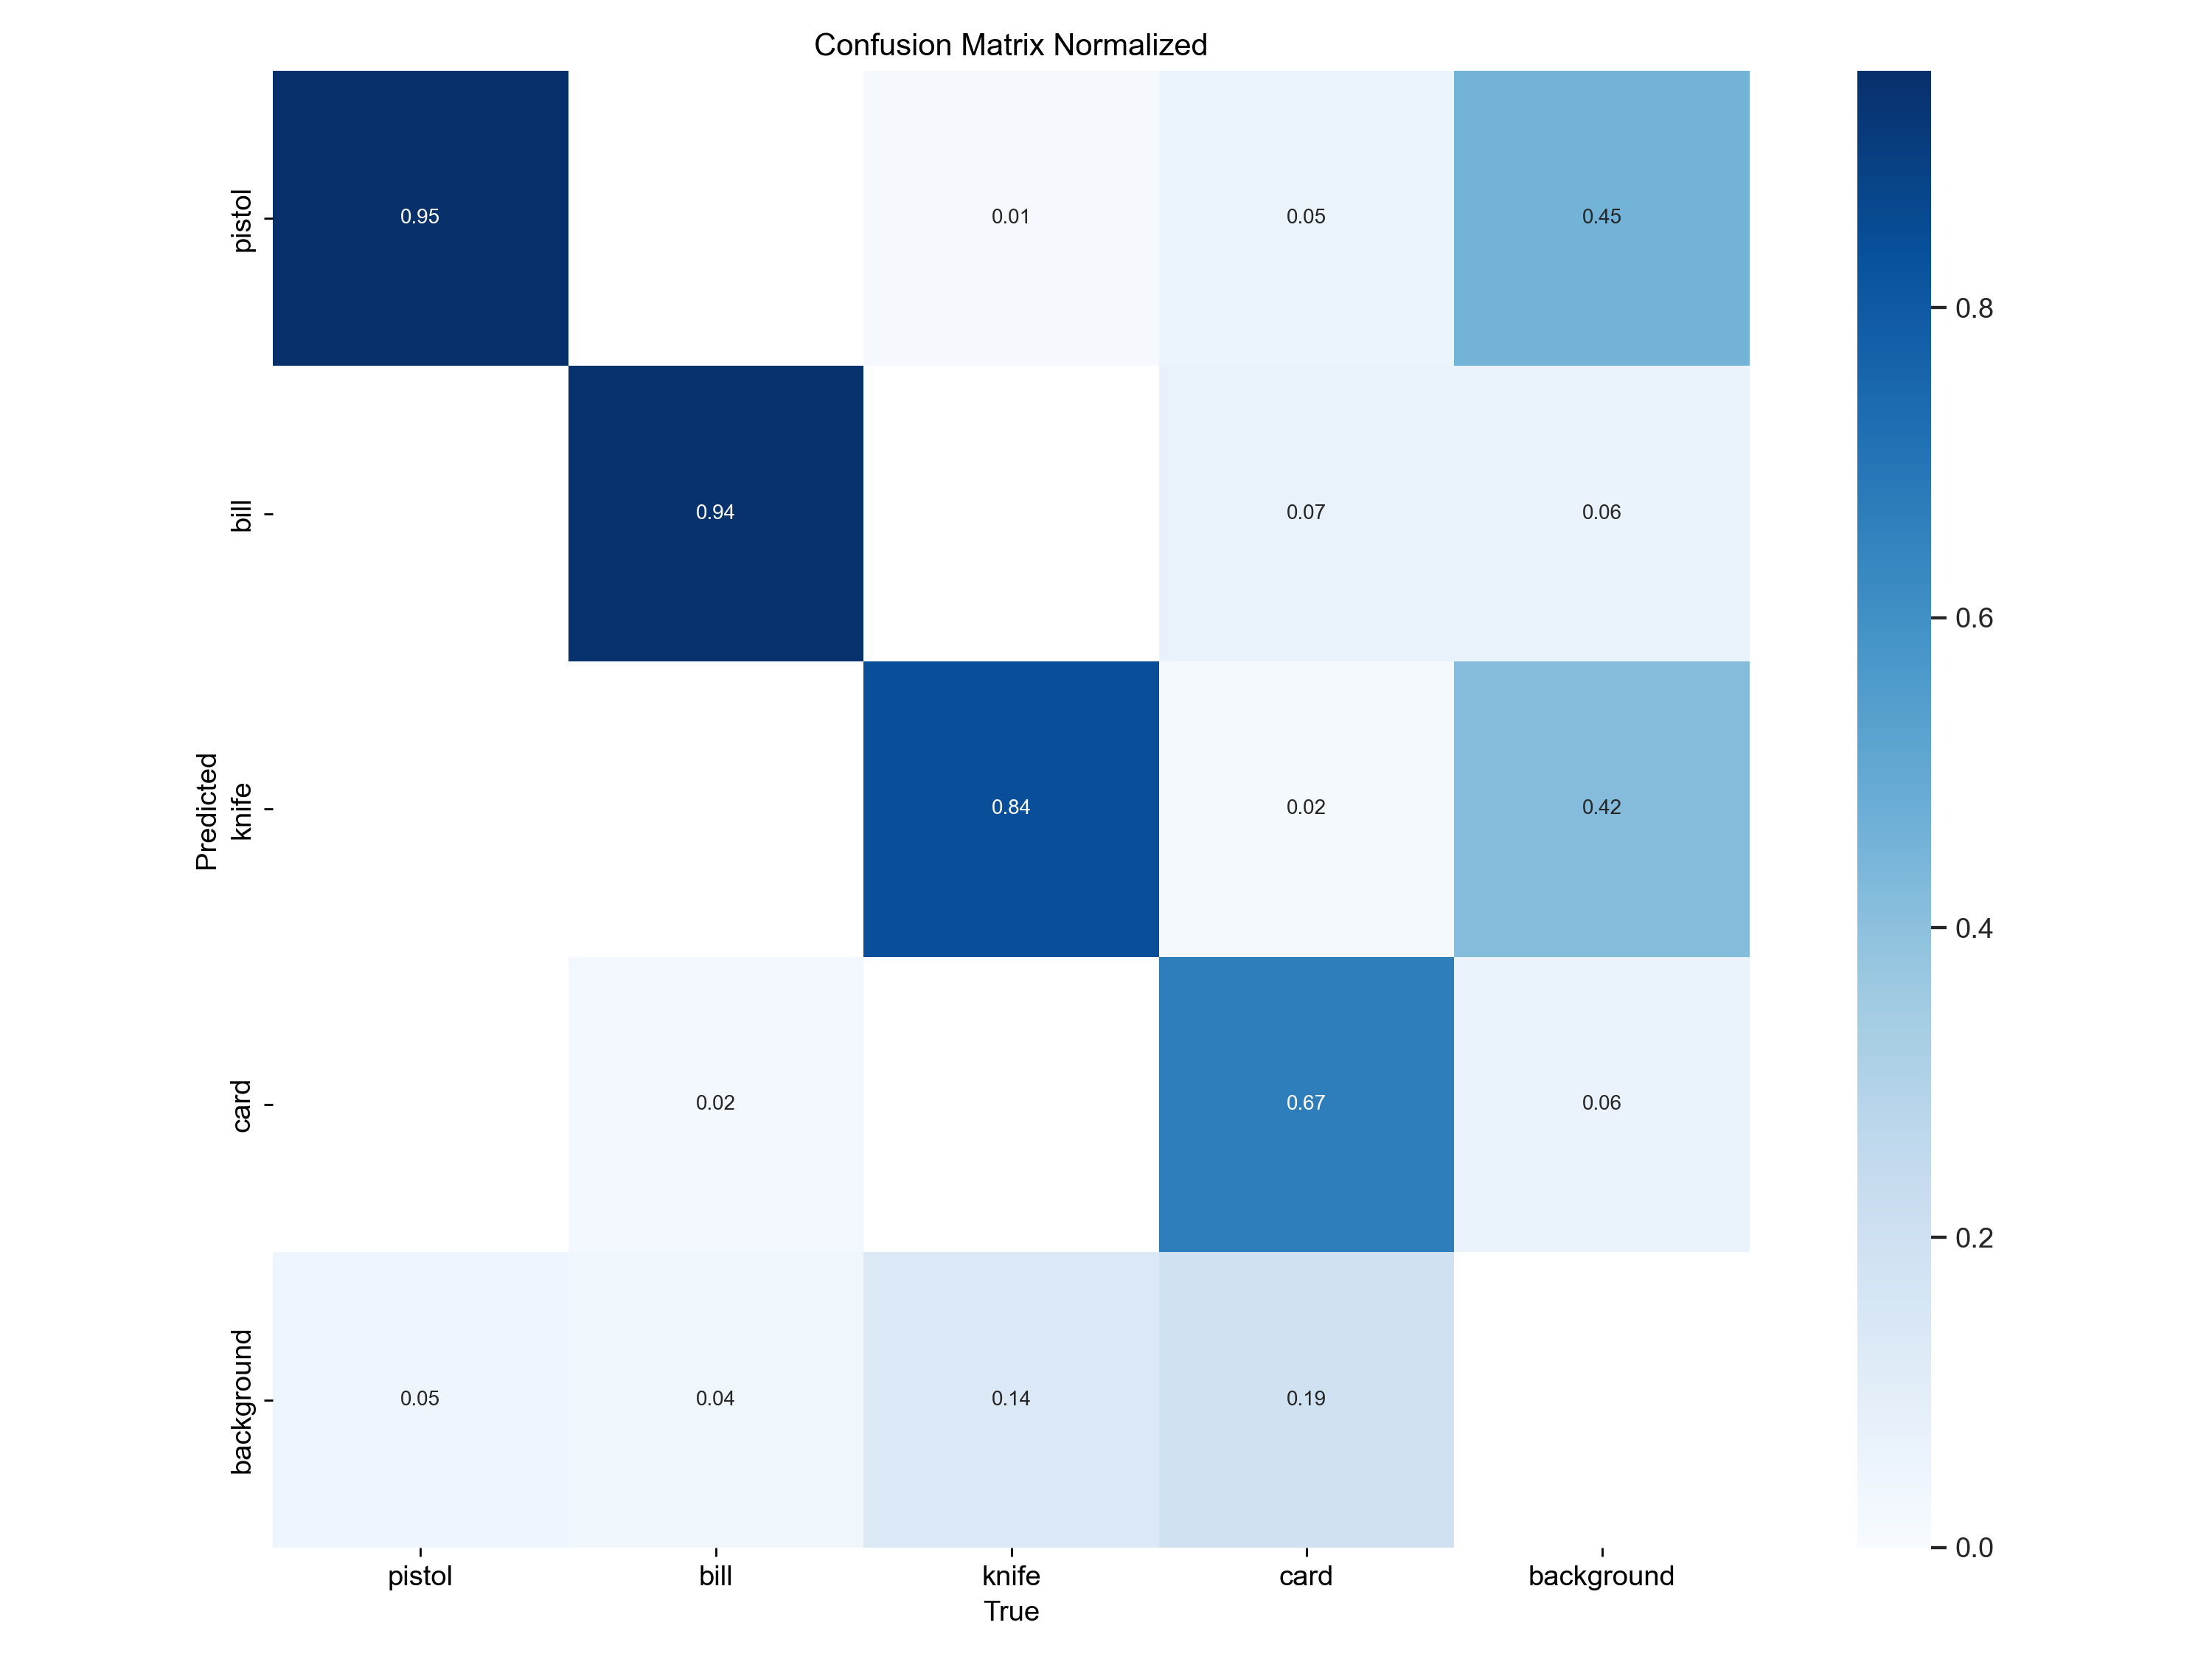

In [21]:
from IPython.display import display, Image
Image(filename=f'runs/detect/train/confusion_matrix_normalized.png', width=700)

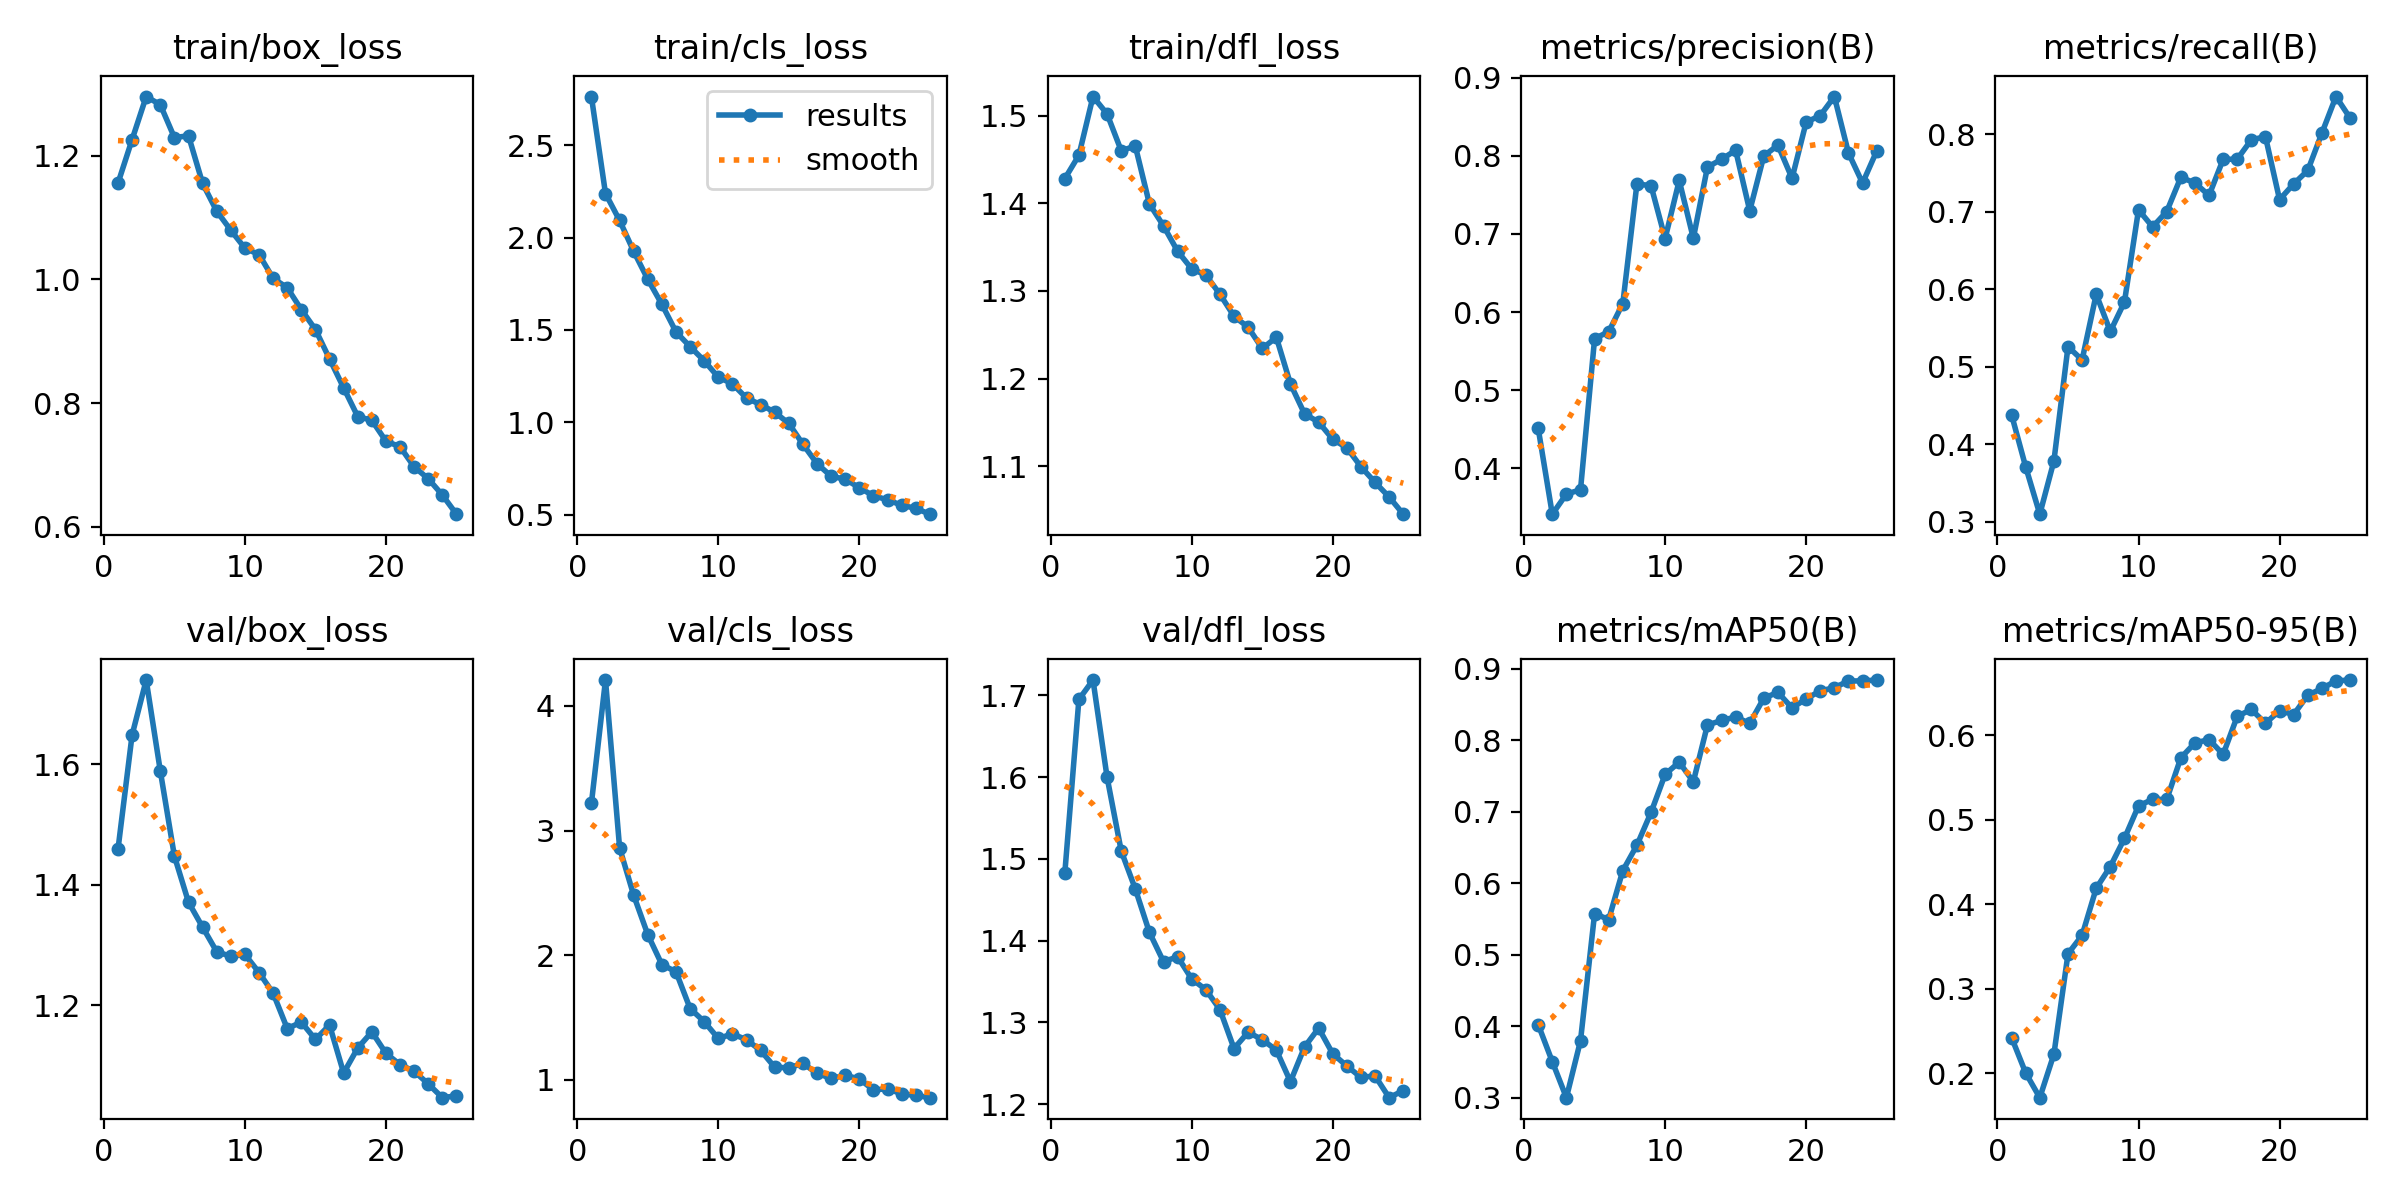

In [23]:
Image(filename=f'runs/detect/train/results.png', width=700)

In [27]:
import subprocess

# YOLOv8 komanda za validaciju
command = [
    "yolo",
    "task=detect",
    "mode=val",
    "model=runs/detect/train/weights/best.pt",
    "data=dataset.yaml"
]

# Pokretanje komande sa real-time ispisom
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

# Čitanje izlaza u realnom vremenu
for line in process.stdout:
    print(line, end='')  # Korišćenje end='' sprečava dvostruki prelaz u nov red
process.stdout.close()
process.wait()

Ultralytics 8.3.29 ðŸš€ Python-3.12.3 torch-2.5.1+cpu CPU (AMD Ryzen 3 3200G with Radeon Vega Graphics)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

val: Scanning C:\Users\Korisnik\Desktop\YOLOv8\dataset\data\labels\test.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|##########| 400/400 [00:00<?, ?it/s]
val: Scanning C:\Users\Korisnik\Desktop\YOLOv8\dataset\data\labels\test.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|##########| 400/400 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|4         | 1/25 [00:01<00:32,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|8         | 2/25 [00:02<00:30,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)

0

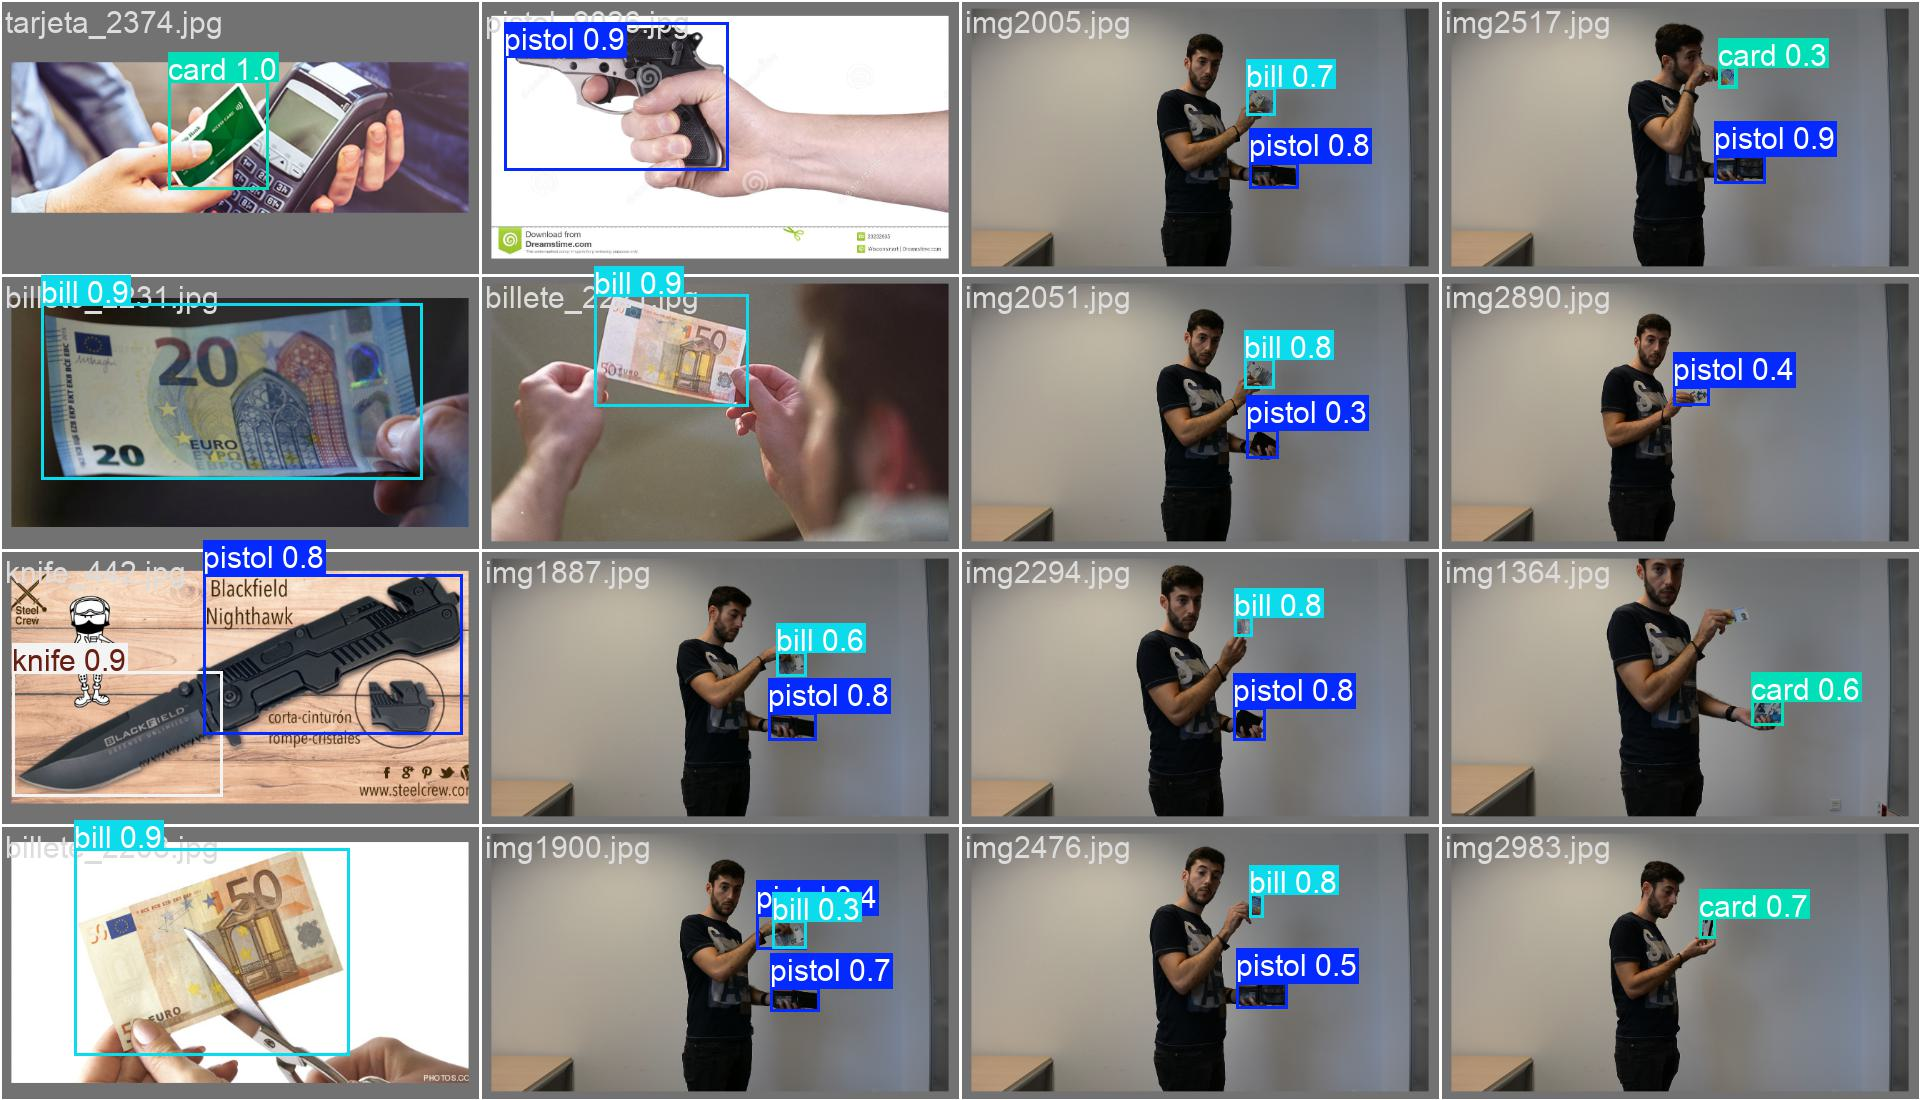

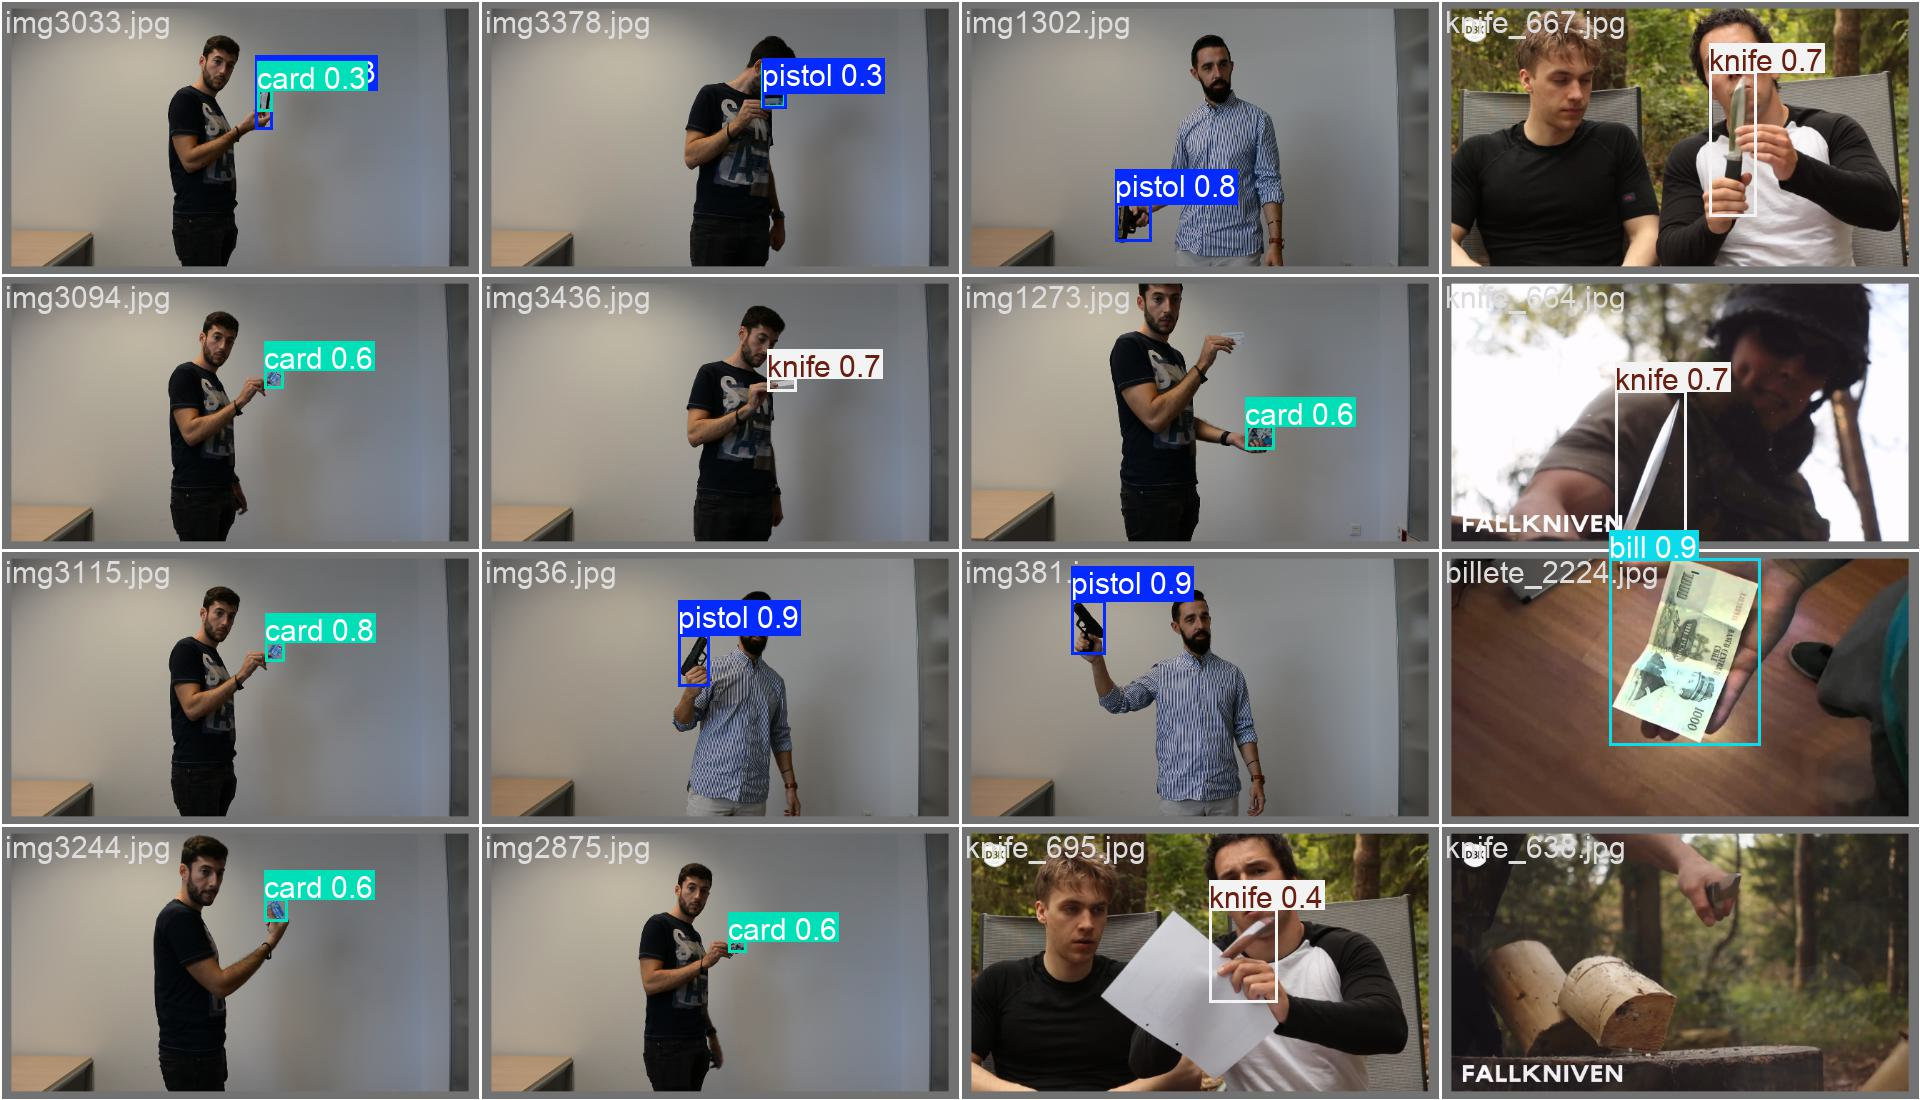

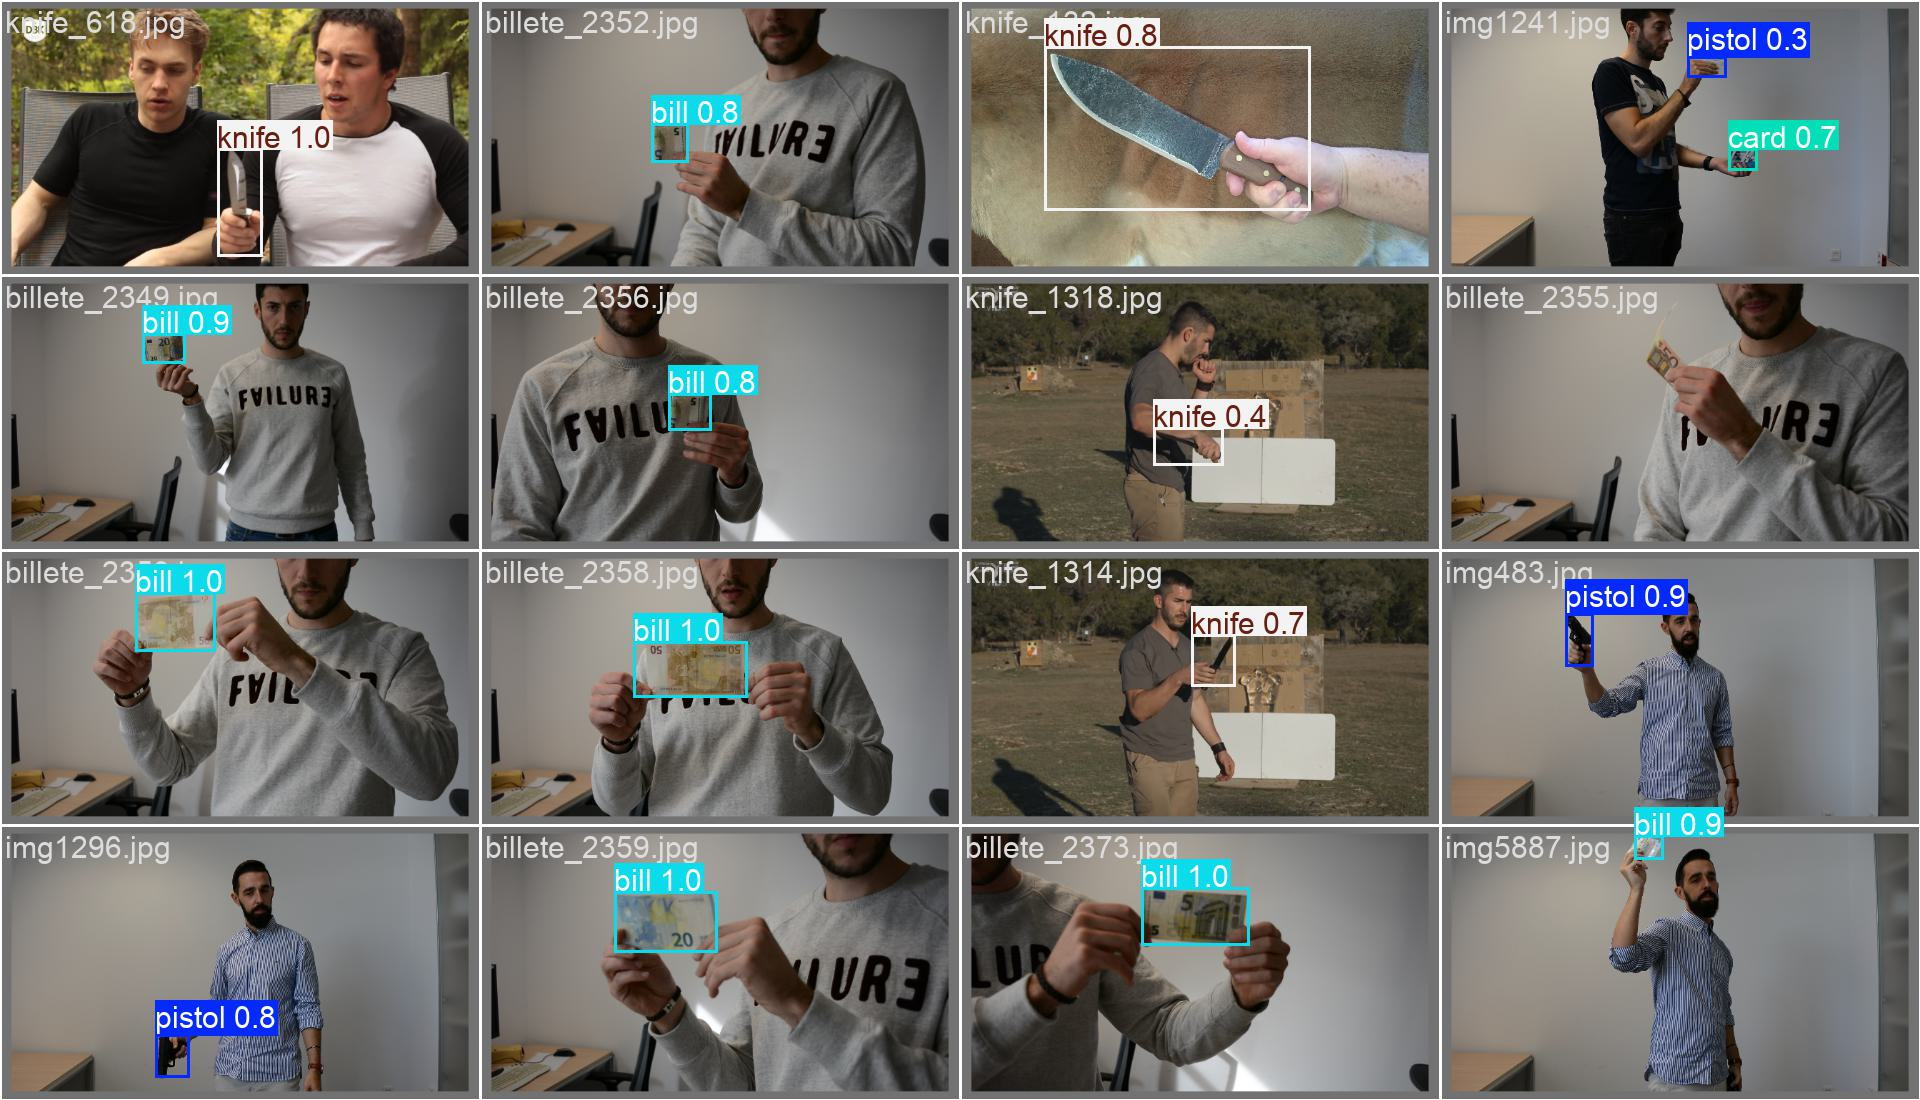

In [29]:
for image_path in glob.glob(f'runs/detect/val/*_pred.jpg'):
    display(Image(filename=image_path, width=700))
    print("\n")